Building the dataset of numerical data

In [ ]:
### PUT MAIN HERE ###

In [1]:
# Machine Learning Challenge
# Course: Machine Learning (880083-M-6)
# Group 58
 
##########################################
#             Import packages            #
##########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import yake  #NOTE: with Anaconda: conda install -c conda-forge yake

##########################################
#      Import self-made functions        #
##########################################
from CODE.data_preprocessing.split_val import split_val
from CODE.data_preprocessing.find_outliers_tukey import find_outliers_tukey
from CODE.data_preprocessing.missing_values import missing_values1
from CODE.data_preprocessing.missing_values import missing_values2

#feature based on the title of the paper
from CODE.features.length_title import length_title

# features based on 'field_of_study' column 
from CODE.features.field_variety import field_variety         
from CODE.features.field_popularity import field_popularity
from CODE.features.field_citations_avarage import field_citations_avarage 

# features based on the topics of the paper
from CODE.features.topic_citations_avarage import topic_citations_avarage
from CODE.features.topic_variety import topics_variety
from CODE.features.topic_popularity import topic_popularity
from CODE.features.topic_citations_avarage import topic_citations_avarage

# features based on the abstract of the paper
from CODE.features.keywords import best_keywords
from CODE.features.abst_words import abst_words
from CODE.features.abst_words import abst_count

# features based on the venue of the paper
from CODE.features.venue_popularity import venue_popularity
from CODE.features.venue_citations import venues_citations

from CODE.features.age import age

# features based on the authors of the paper
from CODE.features.author_h_index import author_h_index
from CODE.features.paper_h_index import paper_h_index
from CODE.features.team_size import team_size
from CODE.features.author_database import author_database
print("Imports complete")

##########################################
#              Load datasets             #
##########################################
# Main datasets
data = pd.read_json('DATA/train.json')      # Training set
test = pd.read_json('DATA/test.json')       # Test set

# Author-centric datasets
#   These datasets were made using our self-made functions 'citations_per_author' (for the author_citation_dic)
#   These functions took a long time to make (ballpark ~10 minutes on a laptop in 'silent mode'), so instead we 
#   decided to run this function once, save the data, and reload the datasets instead of running the function again. 
import pickle
with open('my_dataset1.pickle', 'rb') as dataset:
    author_citation_dic = pickle.load(dataset)
with open('my_dataset2.pickle', 'rb') as dataset2:
    author_db = pickle.load(dataset2)
print("Data loaded")

##########################################
#       drop na rows          #
##########################################
data.dropna(axis='index', how = 'any')  # not helpful over missing_values.

##########################################
#        Missing values handling         #
##########################################
missing_values1(data)  # keep this on even with dropna; should be redundant but it seems to be needed...
missing_values1(test)  # this needs to stay on

##########################################
#       Create basic numeric df          #
##########################################
num_X = data.copy(deep = True)

##########################################
#            Feature creation            #
##########################################
"""
FEATURE DATAFRAME: num_X

ALL: After writing a funtion to create a feature, please incorporate your new feature as a column on the dataframe below.
This is the dataframe we will use to train the models.

DO NOT change the order in this section if at all possible
"""
num_X['title_length'] = length_title(data)      # returns a numbered series with wordlength of the title
test['title_length'] = length_title(test)
num_X['field_variety'] = field_variety(data)    # returns a numbered series with amount of fields
test['field_variety'] = field_variety(test)    # returns a numbered series with amount of fields
num_X['field_popularity'], test['field_popularity'] = field_popularity(data, test) # returns a numbered series with 
num_X['field_citations_avarage'], test['field_citations_avarage']  = field_citations_avarage(data, test) # returns a numbered series
num_X['team_sz'] = team_size(data)           # returns a numbered series
test['team_sz'] = team_size(test)           # returns a numbered series
num_X['topic_variety'] = topics_variety(data)    # returns a numbered series
test['topic_variety'] = topics_variety(test)    # returns a numbered series
num_X['topic_popularity'], test['topic_popularity']= topic_popularity(data, test) # returns a numbered series
num_X['topic_citations_avarage'], test['topic_citations_avarage'] = topic_citations_avarage(data, test) # returns a numbered series
num_X['venue_popularity'], num_X['venue'], test['venue_popularity'], test['venue'] = venue_popularity(data, test)  # returns a numbered series and a pandas.Series of the 'venues' column reformatted 
num_X['open_access'] = pd.get_dummies(data["is_open_access"], drop_first = True)  # returns pd.df (True = 1)
test['open_access'] = pd.get_dummies(test["is_open_access"], drop_first = True)  # returns pd.df (True = 1)
num_X['age'] = age(data)               # returns a numbered series. Needs to be called upon AFTER the venues have been reformed (from venue_frequency)
test['age'] = age(test)               # returns a numbered series. Needs to be called upon AFTER the venues have been reformed (from venue_frequency)
num_X['venPresL'], test['venPresL'] = venues_citations(data, test)   # returns a numbered series. Needs to be called upon AFTER the venues have been reformed (from venue_frequency)
keywords = best_keywords(data, 1, 0.954, 0.955)    # from [data set] get [integer] keywords from papers btw [lower bound] and [upper bound] quantiles; returns list
num_X['has_keyword'] = abst_words(data, keywords)#returns a numbered series: 1 if any of the words is present in the abstract, else 0
test['has_keyword'] = abst_words(test, keywords)#returns a numbered series: 1 if any of the words is present in the abstract, else 0
num_X['keyword_count'] = abst_count(data, keywords) # same as above, only a count (noot bool)
test['keyword_count'] = abst_count(test, keywords) # same as above, only a count (noot bool)

### ---------------log values: this is not great code right now. And not really helpful - adds about .01 to .015 at best.
# Any columns that we build log transformations for should have no zeros and give real values to nans
# Also we would have to convert back from log for the predict: there is somehing about this in one of the documents somewhere...
# Let's Log
num_X['nlog_year'] = np.log(num_X['year'])
num_X['nlog_title_length'] = np.log(num_X['title_length'])
num_X['nlog_field_citations_avarage'] = np.log(num_X['field_citations_avarage'])
num_X['nlog_topic_popularity'] = np.log(num_X['topic_popularity'].astype(np.float64))
num_X['nlog_venue_popularity'] = np.log(num_X['venue_popularity'].astype(np.float64))

data.loc[num_X['team_sz'].isnull(), 'team_sz'] = num_X['team_sz'].median()  # fills 13 zero values
num_X['nlog_team_sz'] = np.log(num_X['team_sz'].astype(np.float64)) 


num_X['citations'] = np.log(num_X['citations'].astype(np.float64)) 



##I would really like to get references to log

# Author H-index
author_db, data['authors'] = author_database(data)
_, test['authors'] = author_database(test) # reformatting authors name from test database
num_X['h_index'], test['h_index'] = paper_h_index(data, author_citation_dic, test) # Returns a numbered series. Must come after author names have been reformatted.

"""
END do not reorder
"""
print("Features created")
##########################################
#    Filling specific missing values     #
##########################################
missing_values2(num_X)
missing_values2(test)
      
### Drop columns containing just strings or boolean
num_X = num_X.drop(['authors', 'abstract', 'topics', 'title', 'venue', 'doi', 'fields_of_study', 'is_open_access'], axis = 1)
test = test.drop(['authors', 'abstract', 'topics', 'title', 'venue', 'fields_of_study', 'is_open_access'], axis = 1)

### Drop duplicate rows - this is a lenient definition, but it returns a very small number of rows, so I like it better than a full match 
duplicate = data[data.duplicated(['title', 'year'])]
a = list(duplicate.index)
num_X = num_X.drop(labels = a)

print("Missing values handled")
##########################################
#    Outlier detection 1: threshold      #
##########################################
# 9658 rows in the full num_X
# 9494 rows with all turned on

num_X = num_X[num_X['references'] < 500]
num_X = num_X[num_X['team_sz'] < 40]
num_X = num_X[num_X['topic_variety'] < 60]
num_X = num_X[num_X['venPresL'] < 300]
num_X = num_X[num_X['h_index'] < 30]


print(num_X.shape)
num_X = num_X.replace([np.inf, -np.inf], np.nan)
num_X = num_X.dropna(axis='index', how = 'any')  # the logging made some wonky numbers
print(num_X.shape)


##########################################
#            Train/val split             #
##########################################
X_train, X_val, y_train, y_val = split_val(num_X, target_variable = 'citations')
print("Data split")




##########################################
#     Outlier detection 2: Quantile      #
##########################################
### MODEL code for outlier detection

# print(list(X_train.columns))

out_y = (find_outliers_tukey(x = y_train['citations'], top = 93, bottom = 0))[0]
out_rows = out_y

# out_X = (find_outliers_tukey(x = X_train['team_sz'], top = 99, bottom = 0))[0]
# out_rows = out_y + out_X

out_rows = sorted(list(set(out_rows)))
X_train = X_train.drop(labels = out_rows)
y_train = y_train.drop(labels = out_rows)

# Potential features to get rid of: team_sz; year and age are perfect correlates
print("Outliers handeled")




Imports complete
Data loaded


C:\Users\r_noc\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Features created
Missing values handled
(9487, 24)
(8302, 24)
Data split
Outliers handeled


In [65]:

## you can skip this - wrong place
# drop the unlogged version of the cols so they don't get counted twice. 

num_X = num_X.drop(['year', 'title_length', 'field_citations_avarage', 'topic_popularity', 'venue_popularity', 'team_sz'], axis = 1)


In [67]:
sum(num_X['h_index'] == 0)
print(num_X.isnull().any().any())
print(np.isinf(num_X).any().any())

False
False


In [41]:
# Let's log everything

# Try
#num_X['nlog_references'] = np.log(num_X['references'])

#num_X['nlog_venPresL'] = np.log(num_X['venPresL'])  # 39 zero values
#num_X['nlog_h_index'] = np.log(num_X['h_index']) # 170 zero values
#num_X['nlog_keyword_count'] = np.log(num_X['keyword_count'].astype(np.float64))  # 159 zero values



# Not suitable for log
#num_X['nlog_topic_citations_avarage'] = np.log(num_X['topic_citations_avarage'])  # 3 zero values
#num_X['nlog_age'] = np.log(num_X['age'])  # 1056 zero values
#num_X['nlog_topic_variety'] = np.log(num_X['topic_variety'].astype(np.float64)) #2081 zero values


In [ ]:
"""
MOVE models here
"""

In [2]:
##########################################
#         Model implementations          #
##########################################
# It takes 20 to 25 minutes to run all models


from CODE.models.regression import simple_linear
from CODE.models.regression import log_reg
from CODE.models.regression import sdg_reg
from CODE.models.regression import poly_reg
from CODE.models.regression import pois_reg
from CODE.models.non_linear import de_tree_reg
from CODE.models.non_linear import kn_reg
from CODE.models.non_linear import my_svr
from CODE.models.non_linear import mlp_reg
"""
IMPLEMENT models here: to run a model, delete the # and run
NOTE: Please do not modify X_train, X_val, y_train, y_val in your model - make new variables if needed
"""

#----------- Check for changes
check_X = X_train.copy(deep = True)
check_y = y_train.copy(deep = True)

#-----------simple regression, all columns
# Leave this on as a baseline
simple_linear(X_train, y_train, X_val, y_val)

"""
MODEL RESULTS:
r2: 0.04709627575317288   r2: 0.05390796592464642 with log columns
MSE: 33.38996
# Worse after extra outlier removal (0.015478)
"""
#-----------logistic regression, all columns
log_reg(X_train, y_train, X_val, y_val)

"""
MODEL RESULTS:
R2: 0.006551953988217396  r2: 0.010046128092099371 w log columns
MSE: 34.07342328208346
# Worse after extra outlier removal (0.003)
"""

#-----------SGD regression, all columns
sdg_reg (X_train, y_train, X_val, y_val)

"""
lr = [ 1, .1, .01, .001, .0001]
learning_rate in ['constant', 'optimal', 'invscaling']:
loss in ['squared_error', 'huber']:

# MODEL RESULTS:
# Best outcome, before extra outlier removal: ('constant', 0.01, 'squared_error', 35.74249957361433, 0.04476790061780822)
# Best outcome after extra outlier removal: ('constant', 0.01, 'squared_error', 37.08290449479669, 0.019303736163186702)
# w log columns: 'invscaling', 0.01, 'squared_error', 32.28100021844441, 0.04811139383501406
"""

#-----------polynomial regression, all columns
poly_reg (X_train, y_train, X_val, y_val, 3)

"""
MODEL RESULTS:
r2: -0.05109 (degree = 2)
r2: -0.0378 (degree = 3)
r2: -5.5816 (degree = 4)
MAE 35.1660
"""

#-----------poisson regression, all columns
pois_reg (X_train, y_train, X_val, y_val)

"""
MODEL RESULTS:
r2: 0.022145    0.05998560070306458  w log features
MAE: 39.21127
"""

#-----------simple linear regression, dropping columns

"""
USE this code to run one of the simple regression models, successively dropping one column
To run, unhash the full function, then unhash the specific model
For a baseline, run the corresponding model above
"""
# summaries = list(X_train.columns)
# print(summaries)

# for i in range(len(summaries)):
#     X_train_small = X_train.copy()
#     X_val_small = X_val.copy()
#     drops = summaries[i]
#     X_train_small.drop(drops, inplace = True, axis=1)
#     X_val_small.drop(drops, inplace = True, axis=1)

#     print("dropped:", summaries[i])
    
#     #simple_linear(X_train_small, y_train, X_val_small, y_val)  #dropping venue_popularity helps a tiny bit
#     #log_reg(X_train_small, y_train, X_val_small, y_val)


#----------- Random Forrest for Regression
# +/- 5 min to run
de_tree_reg (X_train, y_train, X_val, y_val, 50)

"""
MODEL RESULTS:
r2: 0.03378200504507167   r2: 0.047154787109691454 w log columns
"""

#----------- K-Neighbors for Regression
kn_reg (X_train, y_train, X_val, y_val)

"""
MODEL RESULTS:
r2: 0.05784278300196066   r2: 0.061875014890595215 w log columns
"""

# ----------- SVR
# from sklearn.svm import SVR
# svr = SVR()
# model = svr.fit(X_train, np.ravel(y_train))
# r_sq1 = model.score(X_val, y_val)
# print('r2 scr:', r_sq1)
# print()

# ----------- SVC
# from sklearn.svm import SVC
# svc = SVC()
# model = svc.fit(X_train, np.ravel(y_train))
# r_sq1 = model.score(X_val, y_val)
# print('r2 scr:', r_sq1)
# print()

#-----------  Multi-layer Perceptron for Regression
mlp_reg (X_train, y_train, X_val, y_val) 

"""
OPTIONS:
activation= 'identity', 'logistic', 'tanh', 'relu'
solver= 'lbfgs', 'sgd', 'adam'
lr= 'constant', 'invscaling', 'adaptive'
DEFAULT values: maxit=500, activation='relu', solver='adam', alpha=0.0001, lr='constant'

MODEL RESULTS:
r2: 0.005729150866153665
score: 0.005729150866153665
"""

print("data unchanged:")
print(check_X.equals(X_train))
print(check_y.equals(y_train))
print()
print("Models complete")


# ##########################################
# #  Writing file with predicted values    #
# ##########################################
# """
#     Creates new DataFrame with DOI of the papers, 
#     and predicted citation values.
# """

# df_output = pd.DataFrame(columns = ['doi','citations'])

# dict_output = {}

# y_test = model.predict(test.drop(['doi'], axis=1))
# for index, i_paper in test.iterrows():
#     df_output.loc[index, 'doi'] = i_paper['doi'] 
#     df_output.loc[index, 'citations'] = y_test[index]

# list_dic_output = df_output.to_dict(orient = 'records')

# import json

# jsonOutput = json.dumps(list_dic_output, indent = 4)
# with open('OUTPUT/predicted.json', 'w') as f:
#     json.dump(jsonOutput, f)


LinearRegression r2: 0.384205467204331
LinearRegression MAE: 0.919949123606216



ValueError: Unknown label type: 'continuous'

In [3]:
10.0 ** -np.arange(1, 7)

array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])

In [ ]:
"""
-----------------------------------------------------------------------------------------------------------
------------------------------ EXPLORE and VISUALIZE ------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
"""
"""
"""

In [ ]:
#### STOP - ONLY if needed
# Allows printing full text
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [ ]:
### FOR: exploring the new dataframe with numerical columns
num_X

In [ ]:
## how many na?
#sum([True for i, row in num_X.iterrows() if any(row.isnull())])
print(data.shape[0] - data.dropna().shape[0])
print(data['year'].isna().sum())
print(data['references'].isna().sum())
print(data['is_open_access'].isna().sum())
print(data['year'].isna().sum())
print(data['references'].isna().sum())
print(data['is_open_access'].isna().sum())


<AxesSubplot:>

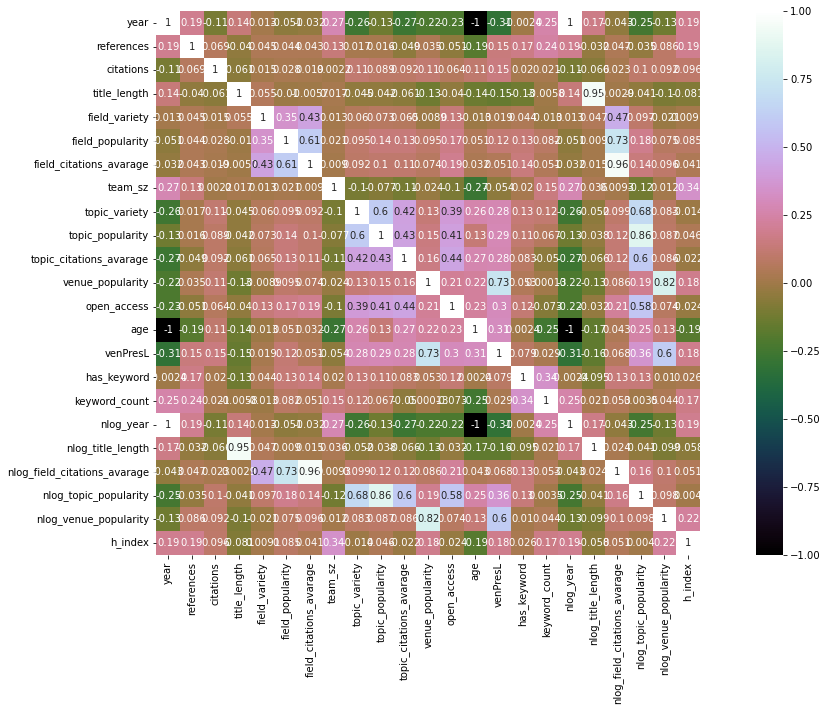

In [61]:
"""
Look at some correlations - full num_X
"""
# names: X_train, X_val, y_train, y_val

# From: https://www.kaggle.com/ankitjha/comparing-regression-models
import seaborn as sns
corr_mat = num_X.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')


<AxesSubplot:xlabel='references', ylabel='citations'>

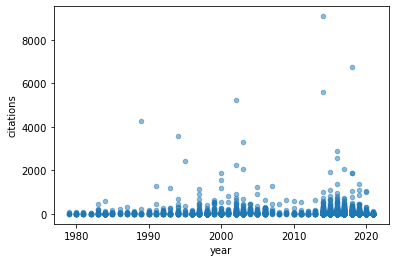

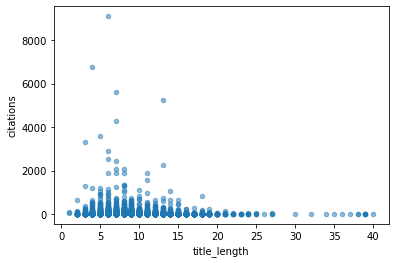

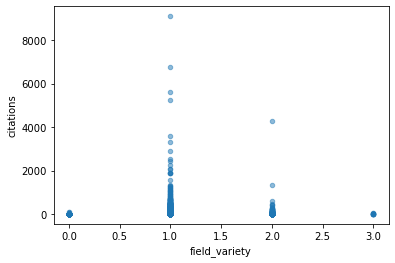

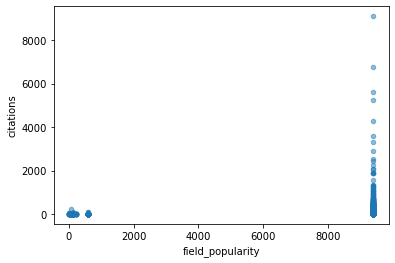

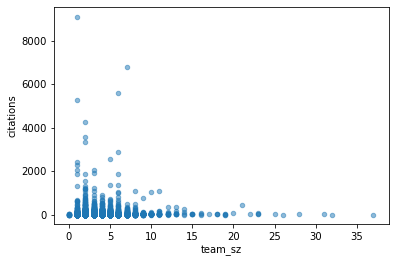

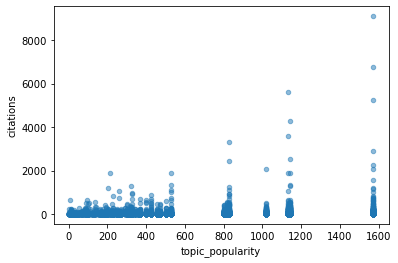

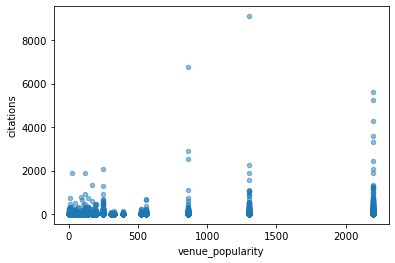

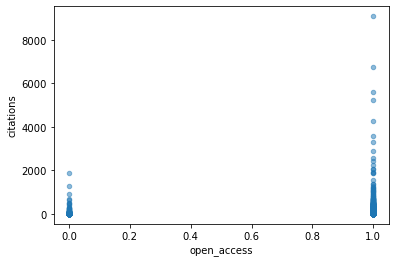

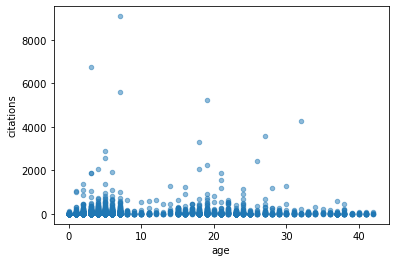

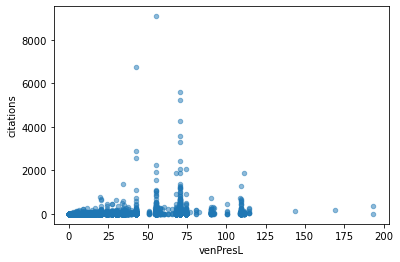

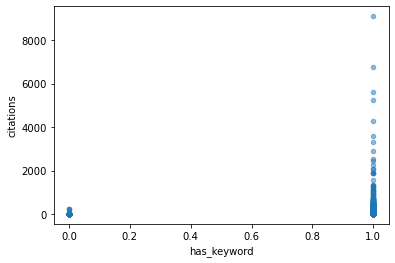

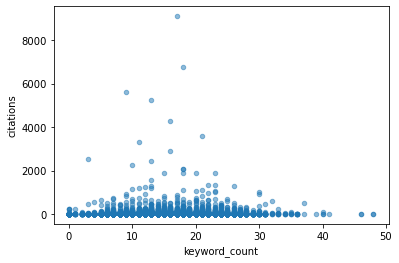

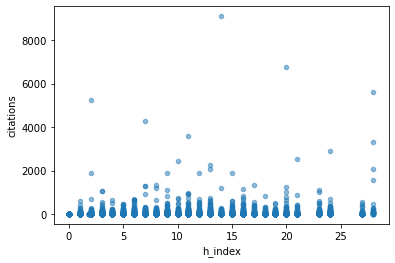

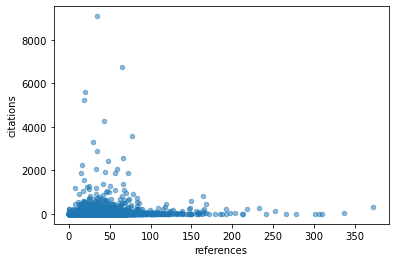

In [40]:
"""
Plots of each column against y
"""
import matplotlib as plt
num_X.plot.scatter(x="year", y="citations", alpha=0.5)
num_X.plot.scatter(x="title_length", y="citations", alpha=0.5) # anything over 30 as outlier?
num_X.plot.scatter(x="field_variety", y="citations", alpha=0.5)
num_X.plot.scatter(x="field_popularity", y="citations", alpha=0.5)
#num_X.plot.scatter(x="field_citations_average", y="citations", alpha=0.5)
num_X.plot.scatter(x="team_sz", y="citations", alpha=0.5)  # might have 3 outliers
#num_X.plot.scatter(x="topic_var", y="citations", alpha=0.5) # one outlier; maybe anything over 40
num_X.plot.scatter(x="topic_popularity", y="citations", alpha=0.5)
#num_X.plot.scatter(x="topic_citations_average", y="citations", alpha=0.5)
num_X.plot.scatter(x="venue_popularity", y="citations", alpha=0.5)
num_X.plot.scatter(x="open_access", y="citations", alpha=0.5)
num_X.plot.scatter(x="age", y="citations", alpha=0.5)
num_X.plot.scatter(x="venPresL", y="citations", alpha=0.5)  # anything over 300 as outlier?
num_X.plot.scatter(x="has_keyword", y="citations", alpha=0.5)
num_X.plot.scatter(x="keyword_count", y="citations", alpha=0.5)
num_X.plot.scatter(x="h_index", y="citations", alpha=0.5)  # anything over 35 as outlier?
num_X.plot.scatter(x="references", y="citations", alpha=0.5)  # might have 3 outliers
#num_X.plot.scatter(x="field_cit", y="citations", alpha=0.5)

In [ ]:
## Per column histogram, heatmap

num_X.plot.hist(x="year", y="citations", alpha=0.5)
num_X.plot.hist(x="references", y="citations", alpha=0.5)  # might have 3 outliers
num_X.plot.hist(x="title_length", y="citations", alpha=0.5) # anything over 30 as outlier?
num_X.plot.hist(x="team_sz", y="citations", alpha=0.5)  # might have 3 outliers
num_X.plot.hist(x="topic_var", y="citations", alpha=0.5) # one outlier; maybe anything over 40
num_X.plot.hist(x="topic_popularity", y="citations", alpha=0.5)
num_X.plot.hist(x="topic_citations_average", y="citations", alpha=0.5)
num_X.plot.hist(x="venue_popularity", y="citations", alpha=0.5)
num_X.plot.hist(x="open_access", y="citations", alpha=0.5)
num_X.plot.hist(x="age", y="citations", alpha=0.5)
num_X.plot.hist(x="venPresL", y="citations", alpha=0.5)  # anything over 300 as outlier?
num_X.plot.hist(x="has_keyword", y="citations", alpha=0.5)
num_X.plot.hist(x="keyword_count", y="citations", alpha=0.5)
num_X.plot.hist(x="h_index", y="citations", alpha=0.5)  # anything over 35 as outlier?
num_X.plot.hist(x="field_cit", y="citations", alpha=0.5)


In [ ]:
### FOR: explore keyword generation
# names: X_train, X_val, y_train, y_val
print("number of keywords:", len(keywords))
print("total train rows:", X_train.shape)
print("numer w keyword:", sum(X_train['has_keyword']))
print()
print(keywords)

# Results are pretty useless as is
#6210 of 6313
#6136 (of 6313) for 1 keyword from the top 1% of papers
#4787 for 2 keywords from top .01% of papers (correlation: 0.036)
#2917 for 1 keyword from top .01% of papers (correlation: 0.049)

In [ ]:
"""
-----------------------------------------------------------------------------------------------------------
------------------------- TEST CODE -----------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
"""
"""
"""

In [ ]:
"""
create a play copy of the training data
"""
play = X_train.copy()
print(list(X_train.columns))
print(X_train.shape)
print(play.shape)

In [ ]:
"""
Create a random mini version of the main 'data' dataframe
"""
import pandas as pd
import numpy as np
mini = data.sample(100, replace = False, axis = 0, random_state = 123)  
print(mini.shape)
print(list(mini.columns))

In [ ]:
"""
Choose your columns
"""

#X_train_small = X_train.loc[ : , 'topic_var':'h_index'].copy()
#X_val_small = X_val.loc[ : , 'topic_var':'h_index'].copy()

drops = ['year', 'team_sz', 'has_keyword']
X_train_small = X_train.copy()
X_train_small.drop(drops, inplace = True, axis=1)

X_val_small = X_val.copy()
X_val_small.drop(drops, inplace = True, axis=1)

In [ ]:
"""
This doesn't work: there are a different number of words in each list.
Maybe just take the top... 20?
"""

def abst_categories (the_data, keywords, mid_keywords, low_keywords):
    abst = the_data['abstract']
    counts = []
    abst_key = []    

    for i in abst:
        if i == None:
            abst_key.append(0)
            continue
        else:
            high = 0
            for word in keywords:
                if word in i.lower():
                    high += 1
            
            mid = 0
            for word in mid_keywords:
                if word in i.lower():
                    mid += 1

            low = 0
            for word in low_keywords:
                if word in i.lower():
                    low +=1
       
#        abst_key = np.argmax(abst_key)
#        abst_key = (max(abst_key)).index

    return pd.Series(abst_key)    


In [ ]:
"""
sklearn:
SVR
KNeighborsRegressor()
DecisionTreeRegression()
"""

"""
from sklearn.svm import SVC  - classifier
#... load the data into X,y
model = SVC(kernel='poly')
model.fit(X,y)
"""


